# Informações dos dados obtidos.

O conjunto de dados contém 9358 resultados médios de 5 sensores químicos de um dispositivo multisensor (PTXX.SX). O dispositivo estava localizado a nível da rua, dentro de uma cidade significativamente poluída. Os dados foram registrados de março de 2004 a fevereiro de 2005 (um ano). Valores ausentes são marcados com o valor -200. A medida de outros sensores também está disponível e algumas podem ser redundantes. ***A variável chave a ser analisada é PT08.S1 (CO), concentração de CO na atmosfera.***
Informação das colunas:

1.  Date (DD/MM/YYYY)
2.  Time (HH.MM.SS)
3.  PT08.S1 (CO) – Variável de predição
4.  Non Metanic HydroCarbons Concentration (mg/m^3)
5.  Benzene Concentration (mg/m^3)
6.  PT08.S2 (NMHC)
7.  NOx Concentration (ppb)
8.  PT08.S3 (NOx)
9.  NO2 Concentration (mg/m^3)
10. PT08.S4 (NO2s)
11. PT08.S5 (O3)
12. Temperature (C)
13. Relative Humidity (%)
14. AH Absolute Humidity
15. Dia da Semana	
16. Mês
17. Target_log
18. Target_log_dff_1
19. Estações_Inverno	
20. Estações_Outono	
21. Estações_Primavera	
22. Estações_Verão

# Objetivo
 
* A parte anterior foi encarregada de testar algumas variáveis criadas. Agora será avaliado diversos modelos de Machine Learning.
* A primeira parte é encarregada de encontrar os melhores parâmetros para os modelos pré - selecionados.
* A segunda parte é de ver como cada variável afeta o desepenho do melhor modelo.
 
* Modelos testados:
 * Floresta aleatória.
 * Light Gradient Boosting Machine.
 
 
# Metodologia.
 
* Os dados serão avaliados pela validação cruzada  respeitando a dependência temporal.
* A métrica utilizada é a MAPE. 

 



# Instalando biblioteca

In [1]:
!pip install git+git://github.com/Hvass-Labs/scikit-optimize.git@dd7433da068b5a2509ef4ea4e5195458393e6555`

/bin/bash: -c: line 0: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [2]:
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 6.7 MB/s 


# Bibliotecas

In [3]:
# import pandas as pd
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')
import seaborn as sns
import statsmodels.tsa.stattools
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set_style("whitegrid")
import statistics
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import wilcoxon
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import skopt
from skopt import gp_minimize, forest_minimize
from skopt import forest_minimize
from lightgbm import LGBMRegressor

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Funções

In [4]:
def MAPE(y_pred,Y_teste):
  return np.mean(100*np.abs(y_pred - Y_teste)/np.abs(Y_teste))

def validation(X,Y,model,flag,Date):
  Ypred = []
  Yv    = []
  tscv = TimeSeriesSplit(n_splits=10)
  vetor_MAPE = np.zeros(10) 
  i = 0
  for linhas_treino, linhas_valid in tscv.split(X):    
    X_t, X_v = X.iloc[linhas_treino], X.iloc[linhas_valid]
    y_t, y_v = Y[linhas_treino], Y[linhas_valid]

    md                    = model.fit(X_t, y_t)
    y_pred                = md.predict(X_v)

    y_pred = 10**y_pred
    y_v    = 10**y_v
    Ypred.append(y_pred)
    Yv.append(y_v)

    mape = MAPE(y_pred,y_v)
    vetor_MAPE[i] = mape
    i = i + 1

    if flag == 1:
      print('Data:',Date[linhas_valid[0]],'-',Date[linhas_valid[-1]], '->', 'MAPE:',np.format_float_positional(mape,5))

  if flag == 1:
    print("\n")
    print('Mape Geral:',np.format_float_positional(np.mean(vetor_MAPE),5),'Std:',
        np.format_float_positional(np.std(vetor_MAPE),5),'Erro:',np.format_float_positional(np.std(vetor_MAPE)/np.sqrt(10),5))
  
  if flag == 0:  
    return np.mean(vetor_MAPE)
  
  if flag == 1:
    return vetor_MAPE
  if flag ==2:
    return Yv,Ypred

def sep_dados(d,col):
  X_teste = d[d['Date'] > '2004-12-01']
  X_train = d[d['Date'] <= '2004-12-01']

  Y_teste = d[col][d['Date'] > '2004-12-01']
  Y_train = d[col][d['Date'] <= '2004-12-01']
  
  X_train = X_train.drop(columns = ['Date','Target_log'])
  X_teste = X_teste.drop(columns = ['Date','Target_log'])

  Y_train = Y_train.drop(columns = 'Date')
  Y_teste = Y_teste.drop(columns = 'Date')

  return X_train,X_teste,Y_train,Y_teste

def Tuning_LGBM(params):
  lr = params[0]
  max_depth = params[1]
  min_child_samples = params[2]
  subsample = params[3]
  colsample_bytree = params[4]
  n_estimators = params[5]  
  min_df = params[6]
  ngram_range = (1, params[7])


  model = LGBMRegressor(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, 
                        min_child_samples=min_child_samples, subsample=subsample,
                        colsample_bytree=colsample_bytree, bagging_freq=1,n_estimators=n_estimators, random_state=0, 
                        n_jobs=6)

  mape = validation(X,Y,model,0,Date)

  return mape

def Tuning_RF(params):
  max_depth = params[0]
  n_estimators = params[1]  
  model = RandomForestRegressor(n_estimators = n_estimators,max_depth=max_depth,random_state = 10) # modelo padrão
  mape = validation(X_train,Y_train,model,0,Date)
  return mape



# Importado os dados

In [5]:
df = pd.read_csv('/content/drive/My Drive/new_dados4.csv',encoding = "UTF-8")

In [6]:
df.head()

,Unnamed: 0,Date,Time,C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Dia da Semana,Mês,Target_log,Target_log_dff_1,Estações_Inverno,Estações_Outono,Estações_Primavera,Estações_Verão
0,0,2004-03-10,21,9.2,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2,3,3.138618,3.146748,0,0,1,0
1,1,2004-03-10,22,6.5,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848,2,3,3.104487,3.138618,0,0,1,0
2,2,2004-03-10,23,4.7,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603,2,3,3.078094,3.104487,0,0,1,0
3,3,2004-03-11,0,3.6,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702,3,3,3.073718,3.078094,0,0,1,0
4,4,2004-03-11,1,3.3,609.0,45.0,1579.0,60.0,1276.0,620.0,10.7,59.7,0.7648,3,3,3.055378,3.073718,0,0,1,0


In [7]:
df =df.drop(columns = ['Unnamed: 0']) # Excluido colunas que não estão adicionado informações redundate.

# Separando os dados

In [8]:
X_train,X_teste,Y_train,Y_teste = sep_dados(df,'Target_log')

In [9]:
Date = df['Date']

In [10]:
X = df.drop(columns = ['Target_log','Date'])
Y = df['Target_log']

# LGBM

In [11]:
space = [(1e-3, 1e-1, 'log-uniform'), # lr
          (1, 10), # max_depth
          (1, 20), # min_child_samples
          (0.05, 1.), # subsample
          (0.05, 1.), # colsample_bytree
          (100,1000), # n_estimators
          (1,5), # min_df
          (1,5)] # ngram_range

res = forest_minimize(Tuning_LGBM, space, random_state=160745, n_random_starts=40, n_calls=40, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 31.7427
Function value obtained: 4.4481
Current minimum: 4.4481
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.9234
Function value obtained: 4.2899
Current minimum: 4.2899
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 45.6664
Function value obtained: 5.2830
Current minimum: 4.2899
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 287.9843
Function value obtained: 6.6309
Current minimum: 4.2899
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 46.5907
Function value obtained: 4.7721
Current minimum: 4.2899
Iteration No: 6 started. Evalu

In [12]:
print('ls:',res.x[0])
print('max_depth :', res.x[1])
print('min_child_samples :', res.x[2])
print('subsample:',res.x[3])
print("colsample_bytree:",res.x[4])
print("n_estimators:",res.x[5])
print("min_df",res.x[6])
print("ngram_range",res.x[7])

ls: 0.027175964288097477
max_depth : 3
min_child_samples : 14
subsample: 0.15198156079213626
colsample_bytree: 0.4706274193258814
n_estimators: 459
min_df 5
ngram_range 4


In [13]:
model = LGBMRegressor(learning_rate=res.x[0], num_leaves=2 ** res.x[1], max_depth=res.x[1], 
                        min_child_samples=res.x[2], subsample=res.x[3],
                        colsample_bytree=res.x[4], bagging_freq=1,n_estimators=res.x[5], random_state=0, 
                        n_jobs=6)

In [14]:
mape = validation(X,Y,model,1,Date)

Data: 2004-04-15 - 2004-05-19 -> MAPE: 6.96313
Data: 2004-05-19 - 2004-06-24 -> MAPE: 6.16178
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.07852
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.60976
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.25387
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.37916
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.50916
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.23688
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.53515
Data: 2005-03-01 - 2005-04-04 -> MAPE: 2.85305


Mape Geral: 4.05805 Std: 1.37807 Erro: 0.43578


# Floresta aleatoria

In [15]:
space = [(1, 20), # max_depth
          (100,1000)]
res1 = forest_minimize(Tuning_RF, space, random_state=160745, n_random_starts=20, n_calls=20, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 86.4319
Function value obtained: 5.1849
Current minimum: 5.1849
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 27.9720
Function value obtained: 10.6919
Current minimum: 5.1849
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 49.3392
Function value obtained: 4.5859
Current minimum: 4.5859
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 22.7540
Function value obtained: 4.5698
Current minimum: 4.5698
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 14.4429
Function value obtained: 7.9556
Current minimum: 4.5698
Iteration No: 6 started. Eval

In [16]:
print('max_depth :', res1.x[0])
print("n_estimators:",res1.x[1])

max_depth : 15
n_estimators: 348


In [17]:
model = RandomForestRegressor(n_estimators = res1.x[0],
                              max_depth=res1.x[1],random_state = 10) # modelo padrão

In [18]:
mape = validation(X,Y,model,1,Date)

Data: 2004-04-15 - 2004-05-19 -> MAPE: 8.40193
Data: 2004-05-19 - 2004-06-24 -> MAPE: 7.84637
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.57883
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.90372
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.66252
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.90462
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.69524
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.4769
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.29732
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.25586


Mape Geral: 4.60233 Std: 1.83859 Erro: 0.58141


* Claramente o modelo do LGBM é bem melhor que o outro logo será visto como as variáveis afetam o seu desepenho.

* Um ponto que vale comentar é de que no último periodo o erro do LGBM 

# Variáveis relevantes.

In [19]:
model = LGBMRegressor(learning_rate=res.x[0], num_leaves=2 ** res.x[1], max_depth=res.x[1], 
                        min_child_samples=res.x[2], subsample=res.x[3],
                        colsample_bytree=res.x[4], bagging_freq=1,n_estimators=res.x[5], random_state=0, 
                        n_jobs=6)

In [20]:
ind = X.columns
mape_lag = []
erro_lag = []

In [21]:
for i in range(len(ind)):
  X_ = X.drop(columns = ind[i])
  print('Variável excluida:',ind[i])
  mape = validation(X_,Y,model,1,Date)
  mape_lag.append(np.mean(mape))
  erro_lag.append(np.std(mape)/np.sqrt(5))
  print('\n')

Variável excluida: Time
Data: 2004-04-15 - 2004-05-19 -> MAPE: 7.28493
Data: 2004-05-19 - 2004-06-24 -> MAPE: 6.14096
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.11026
Data: 2004-07-28 - 2004-09-02 -> MAPE: 2.5961
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.27134
Data: 2004-10-07 - 2004-11-10 -> MAPE: 3.43248
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.49903
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.41212
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.55097
Data: 2005-03-01 - 2005-04-04 -> MAPE: 3.22051


Mape Geral: 4.15187 Std: 1.41377 Erro: 0.44707


Variável excluida: C6H6(GT)
Data: 2004-04-15 - 2004-05-19 -> MAPE: 6.68058
Data: 2004-05-19 - 2004-06-24 -> MAPE: 5.86897
Data: 2004-06-24 - 2004-07-28 -> MAPE: 3.7953
Data: 2004-07-28 - 2004-09-02 -> MAPE: 3.14684
Data: 2004-09-02 - 2004-10-07 -> MAPE: 3.90279
Data: 2004-10-07 - 2004-11-10 -> MAPE: 4.36847
Data: 2004-11-10 - 2004-12-14 -> MAPE: 4.86145
Data: 2004-12-14 - 2005-01-22 -> MAPE: 4.77881
Data: 2005-01-22 - 2005-03-01 -> MAPE: 3.97245
Data: 

In [22]:
if np.sum(np.array(mape_lag)< 3.85029) > 0:
  print('Com discarte de variáveis')
else:
  print('Sem descarte de variáveils')

Sem descarte de variáveils


In [23]:
erro = (np.array(mape_lag)/3.85029)*np.sqrt((np.array(erro_lag)**2)/np.array(mape_lag) + ((0.42903**2)/3.85029))


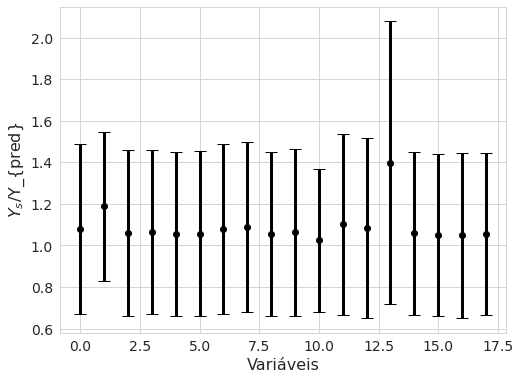

In [47]:
plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.figure(figsize=(8,6))
plt.errorbar(np.arange(len(ind)),np.array(mape_lag)/3.85029,erro, marker='o', linestyle="",color ='black',elinewidth=3,capsize=6)
plt.xlabel('Variáveis',fontsize = 16)
plt.ylabel('$Y_{s}$/Y_{pred}',fontsize = 16)
plt.show()

  * Diversas variáveis causam o mesmo impacto na previsão. A mais relevante entre elas é a log_diff_1.

#Análise de resíduos e vendo o comportamento temporal dos dados.

In [48]:
y_v,y_pred = validation(X,Y,model,2,Date)

In [49]:
y_v= np.concatenate(y_v)
y_pred= np.concatenate(y_pred)

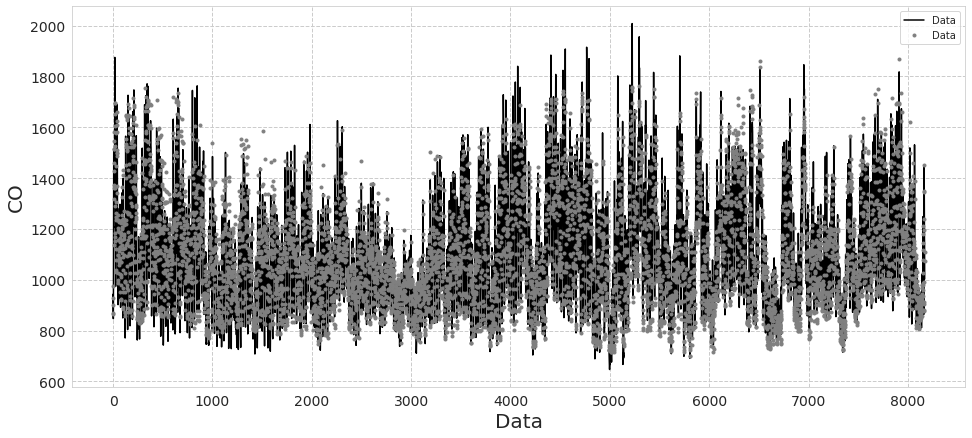

In [50]:
plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=14)



fig, ax =plt.subplots(figsize=(16,7))
ax.plot(y_v,'-', label='Data',color='black')
ax.plot(y_pred,'.', label='Data',color='gray')
plt.grid(linestyle='--', linewidth=1)
ax.set_xlabel('Data',fontsize = 20)
ax.set_ylabel('CO',fontsize = 20)
plt.legend()
plt.show()


* A previsão está conseguindo seguir o comportamento da tendência dos dados de Target.

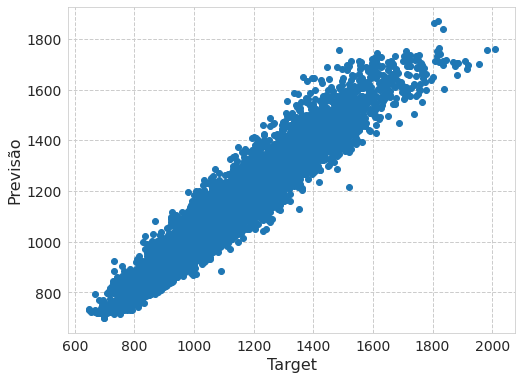

In [51]:
plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.figure(figsize=(8,6))
plt.plot(y_v,y_pred ,'o')
plt.grid(linestyle='--', linewidth=1)
plt.xlabel('Target',fontsize = 16)
plt.ylabel('Previsão',fontsize = 16)
plt.show()

* Existe uma correlação alta entre os dados de Target e previsão isso mostra que o modelo está conseguindo prever bem boa parte do range dos dados de Target.

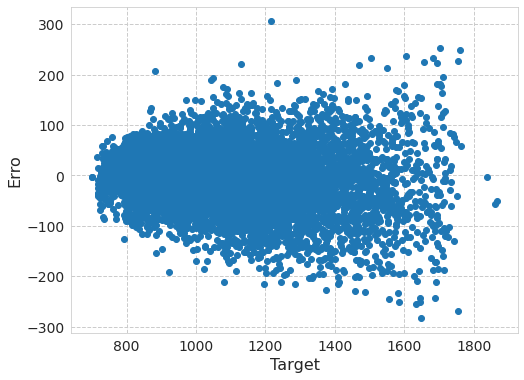

In [52]:
plt.rc('ytick', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.figure(figsize=(8,6))
plt.plot(y_pred,y_v-y_pred ,'o')
plt.grid(linestyle='--', linewidth=1)
plt.xlabel('Target',fontsize = 16)
plt.ylabel('Erro',fontsize = 16)
plt.show()

* Existe uma autocorrelação entre os erros, isso mostra que o modelo ainda pode melhorar.

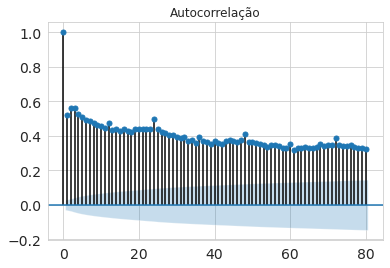

In [53]:
plot_acf(y_v-y_pred, alpha = 0.01, lags=80,title = 'Autocorrelação');

* Existe uma autocorrelação entre os erros, isso mostra que o modelo ainda pode melhorar.

# Conclusão:

* Os resultados mostram que o melhor modelo encontrado foi um LGBM e que ele consegue capturar bem o comportamento dos dados ao longo do tempo, mas aparentemente ele possuem uma dificuldade de prever os valores altos de CO.
 
* Um dos resultados mostram que a uma alta correlação entre os erros, isso deixa explícito que o modelo pode ser melhorado. Mas ele já pode ser levado para produção devido que ele possui um MAPE de 4.05805 Std: 1.37807 Erro: 0.43578.
